In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import datetime
from datetime import timedelta

from matplotlib.dates import date2num


%matplotlib inline
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['#DC7633','#1b9e77','#e7298a','#7570b3'])

# ** GET DATA **

In [2]:
confirmed_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recoveries_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

In [3]:
confirmed_df=confirmed_df.loc[confirmed_df['Country/Region'].isin(['Turkey']),:]
deaths_df=deaths_df.loc[deaths_df['Country/Region'].isin(['Turkey']),:]
recoveries_df=recoveries_df.loc[recoveries_df['Country/Region'].isin(['Turkey']),:]

# ** PLOT OVERVIEW **

In [4]:
first_date = '3/11/20'

def Aggregate(df):
    return df.loc[:,first_date:].sum(axis=0)

def Mask_Nan(df):
    return np.isnan(df.loc[:,first_date:].values.astype(np.float64)).any(axis=0)

def Plotting(confirmed, recoveries, deaths, region='Global', nan_mask=None, fig=None, ax=None):
    """This is the primary plotting command."""
    tick_spacing = 20
    alpha = 0.8
    # Confirmed = active + deaths + recoveries.
    active = pd.Series(confirmed.values.astype(np.int32) - deaths.values.astype(np.int32) - recoveries.values.astype(np.int32),
                           confirmed.index)
    plt.rcParams.update({'font.size':  18})
    if fig is None:
        fig = plt.figure(figsize=(10,8), facecolor=(1, 1, 1))
        ax = fig.gca()
    ax.bar(confirmed.index, confirmed.values, label="Total Case", alpha=0.8)
    ax.bar(recoveries.index, recoveries.values, label="Total Recoveries", alpha=0.8)
    ax.bar(confirmed.index, active, label="Total Active", alpha=0.9)
    ax.bar(deaths.index, deaths.values, label="Total Deaths", alpha=1.0)
    joint = np.asarray([(deaths, "Total Deaths"), (confirmed, "Total Case"), (recoveries, "Total Recoveries"),
                     (active, "Total Active")])
    if nan_mask is None:
        ann_idx = -1
    else:
        ann_idx = np.where(np.logical_not(nan_mask))[-1][-1]
    sortinds = np.argsort([deaths.values[ann_idx], 
                           confirmed.values[ann_idx],
                           recoveries.values[ann_idx],
                           active.values[ann_idx]])
    joint = joint[sortinds]

    for idx, (ser, name) in enumerate(joint.tolist()):
        ax.annotate("{:,} {}".format(int(ser.values[ann_idx]), name), 
                    (ser.index[ann_idx], ser.values[ann_idx]), 
                    (.6, .2*(idx + 1)), 
                    textcoords='axes fraction',
                bbox=dict(boxstyle="round", fc="w", alpha=0.8),
                    fontsize=14,
                arrowprops={'arrowstyle': '->'})
    if nan_mask is not None:
        assert(nan_mask.size == confirmed.index.size)
        for (day_idx, isnan) in enumerate(nan_mask):
            if isnan:
                ax.annotate("Missing some data on {}".format(confirmed.index[day_idx]), 
                    (confirmed.index[day_idx], 0), 
                    (0.6, -0.1),
                            textcoords='axes fraction',
                             bbox=dict(boxstyle="round", fc="gray", alpha=0.8),
                    fontsize=14,
                arrowprops={'arrowstyle': '->'})
                    

    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Number of People", fontsize=15)
    ax.grid('on', which='both', axis='y')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    region_str = region if len(region) < 30 else region[:30] + '...'
    ax.set_title('COVID-19 {}'.format(region_str), fontsize=15, fontweight='bold')
    ax.legend(loc='upper left',prop={'size': 12})

In [5]:
confirmed = Aggregate(confirmed_df)
deaths = Aggregate(deaths_df)
recoveries = Aggregate(recoveries_df)
nan_mask = Mask_Nan(confirmed_df)

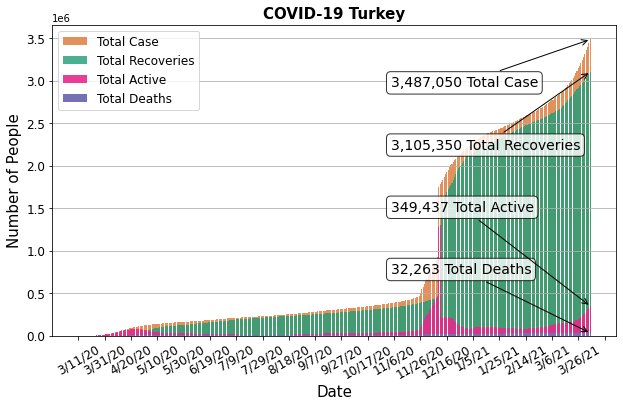

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
Plotting(confirmed, recoveries, deaths, region='Turkey', nan_mask=nan_mask, ax=ax, fig=fig)
ax.xaxis.set_tick_params(labelsize=12, rotation=30)
ax.yaxis.set_tick_params(labelsize=12)

fig.tight_layout()
fig.savefig('Turkey.png', format='png', dpi=600)

# ** Mortality Rate and Recovery Rate **

In [7]:
mortality_rate = []
recovery_rate = []
total_active = []

date = confirmed.index

for i in date:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # active
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append((death_sum/confirmed_sum)*100)
    recovery_rate.append((recovered_sum/confirmed_sum)*100)

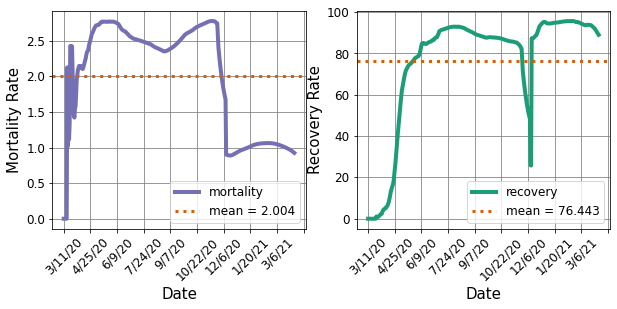

In [8]:
mean_mortality_rate = np.mean(mortality_rate)
mean_recovery_rate = np.mean(recovery_rate)

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(date, mortality_rate, color='#7570b3', linewidth=4)
ax1.axhline(y = mean_mortality_rate, linestyle='dotted', color='#d95f02', linewidth=3)
ax1.legend(['mortality', 'mean = '+ str(round(mean_mortality_rate,3))], prop={'size': 12})

ax1.set_ylabel('Mortality Rate',fontsize=15)
ax1.set_xlabel('Date',fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12, rotation=45)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.grid(b=True, color='gray', linestyle='-')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(45))


ax2.plot(date, recovery_rate, color='#1b9e77', linewidth=4)
ax2.axhline(y = mean_recovery_rate, linestyle='dotted', color='#d95f02', linewidth=3)
ax2.legend(['recovery', 'mean = '+ str(round(mean_recovery_rate,3))], prop={'size': 12})

ax2.set_ylabel('Recovery Rate',fontsize=15)
ax2.set_xlabel('Date',fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12, rotation=45)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(b=True, color='gray', linestyle='-')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(45))

plt.show()

fig2.tight_layout()
fig2.savefig('Mortality-Recovery.png', format='png', dpi=600)